# Analysis

*Remember that we will not grade the notebook itself in the end. Instead, you will submit a report in Markdown format. We recommend you to answer the questions in the report after completing each part in this notebook.*


## Part 1: Conceptual hydrological model

In this assignment, you will implement a (very) simple conceptual hydrological model to predict the discharge of the Geul river in response to precipitation and evapotranspiration. The Geul catchment is located in the province of Limburg in the South-East of the Netherlands (see figure below). In 2021, it was hit by heavy floods.

<figure>
<img src="https://hess.copernicus.org/articles/28/3327/2024/hess-28-3327-2024-f01-web.png" width="50%">
<figcaption> Location of the Geul catchment (<a href="https://doi.org/10.5194/hess-28-3327-2024">Tsiokanos et al., 2024</a>) </figcaption>
</figure>

Conceptual hydrological models predict the discharge from a catchment in response to meteorological forcing based on a mass balance and a simple representation of hydrological processes.
In this assignment, we use a very simplified version of such a conceptual hydrological model where all of the water that can be stored in the catchment is represented by a single reservoir. Precipitation adds to the reservoir whereas evapotranspiration and discharge remove water from the storage.
The following sketch shows the structure of the model we will use.


<img src="https://files.mude.citg.tudelft.nl/GA1.3/conceptual_hydrological_model.svg" width="50%">

The mass balance for the water stored in the catchment per area, $S$ [mm], is:

$$\frac{dS}{dt} = P(t) - \text{ET}(t) - Q(S(t))$$

where $P(t)$ is the precipitation rate [mm/day], $\text{ET}(t)$ is the evapotranspiration rate [mm/day] and $Q$ is the discharge normalized to the catchment area and thus also expressed in [mm/day].

The discharge depends non-linearly on the storage in the catchment:

$$Q(S) = k S^\alpha$$

The evapotranspiration depends on potential evapotranspiration and a term that limits evapotranspiration when it is dry:

$$\text{ET}(t) = \text{ET}_{\text{pot}}(t) \frac{S}{S + S_c}$$

Thus, the full model equation reads:

$$\frac{dS}{dt} = \underbrace{P(t) - \text{ET}_{\text{pot}}(t) \frac{S}{S + S_c} - k S^\alpha}_{f(S(t), t)}$$



<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 1.1:}$

Classify the model equation based on the categories listed under [chapter 2.1](https://mude.citg.tudelft.nl/book/2025/numerical_methods/1-revision-of-concepts.html) of the MUDE textbook.
Also, note the number of states and parameters.
    
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

The model equation is a first-order, non-linear ODE. The terms $S^\alpha$ makes it non-linear.
It has one state ($S$) and three parameters ($k$, $\alpha$, $S_c$).

</p>
</div>

The functions $P(t)$ and $\text{ET}_{\text{pot}}(t)$ are based on measured data (so-called forcing data).
In the following, we will use data on a daily timescale and consider rain and potential evapotranspiration as piecewise constant.

The following code reads in and plots the forcing data. The discharge data comes from the station at Meersen, at the outlet of the catchment.
The meteorological data (precipitation and potential evapotranspiration) are from the weather station in Maastricht.

You do not need to change anything here, just run the cells.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os
import pandas as pd
from urllib.request import urlretrieve
from urllib.parse import urljoin

In [2]:
def download_file_from_mude_server(file_name):
    """Download data files from the MUDE FTP server if they do not exist locally yet.

    Parameters
    ----------
    file_name: str
       Name of the file to download
    """
    if os.path.isfile(file_name):
        print(f"File {file_name} already exists. Skipping the download.")
    else:
        print(f"Downloading {file_name}...")
        url = urljoin("http://files.mude.citg.tudelft.nl/GA1.3/", file_name)
        urlretrieve(url, file_name)

In [3]:
# Download the data files
download_file_from_mude_server("Maastricht_1965_2021.txt")
download_file_from_mude_server("Q_Meerssen_read.csv")

# Read discharge data
q_df = pd.read_csv(
    "Q_Meerssen_read.csv",
    header=0,
    usecols=[2, 4],
    names=(
        "discharge [m3/s]",
        "datetime",
    ),
    parse_dates=True,
)
q_df["datetime"] = pd.to_datetime(q_df["datetime"], format="mixed")
q_daily = q_df.set_index("datetime").resample("d").mean()

# Read meteorological data
df_meteo = pd.read_csv(
    "Maastricht_1965_2021.txt",
    skiprows=46,
    skipinitialspace=True,
    parse_dates=True,
    index_col="YYYYMMDD",
    usecols=["YYYYMMDD", "RH", "EV24"],
)
df_meteo = (
    df_meteo.rename(columns={"RH": "precipitation", "EV24": "evapotranspiration"})
    .rename_axis("datetime")
    .where(lambda x: x >= 0, other=0)  # remove negative values
    .transform(lambda x: x / 10)  # convert from 0.1mm to mm
)

# Merge all data in one dataframe
df = pd.merge(q_daily, df_meteo, on="datetime").loc["2015"]
df["days"] = df.index - df.index[0]

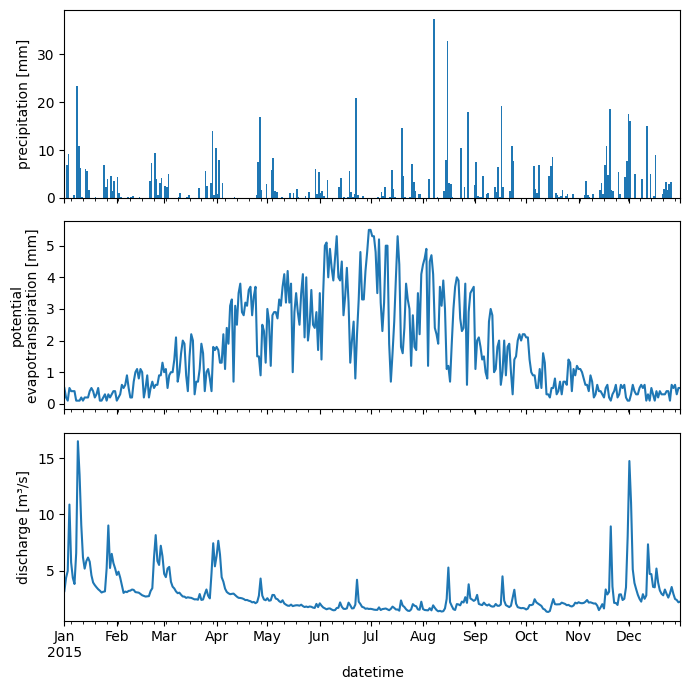

In [4]:
# Plot the data
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 7))
axs[0].stairs(
    edges=df.index.append(pd.Index([df.index[-1] + pd.Timedelta("1 day")])),
    values=df["precipitation"],
    fill=True,
    baseline=0,
)
axs[0].set_ylabel("precipitation [mm]")
df["evapotranspiration"].plot(ax=axs[1])
axs[1].set_ylabel("potential\nevapotranspiration [mm]")
df["discharge [m3/s]"].plot(ax=axs[2])
axs[2].set_ylabel("discharge [m³/s]")

plt.tight_layout()


To predict a discharge for a given precipitation and potential evapotranspiration, we need to solve the ODE that defines the model numerically.
The result will be a time series of the water stored in the catchment $S$, from which we can compute the discharge $Q$ and compare it to measured values.

In the next part of the notebook, we will have a closer look at the implementation of the implicit Euler scheme for solving the ODE numerically.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 1.2:}$
    
The implementation of the implicit Euler scheme for this model will be more complicated than for the model of the falling head test in WS1.3. What is the reason for this?
    
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

In the implicit Euler scheme, the right-hand-side of the ODE is evaluated at the new time step. Therefore, the state at the new time step appears on both sides of the equation. If the model is linear (as in the case of the falling-head-test), it is straight forward to solve the equation for the state at the new time step.

For models where the right-hand-side contains non-linear terms, it is not generally possible to solve the equation of the implicit Euler scheme for the state at the new time step analytically. An additional numerical scheme to solve the equation is thus required.
One option for such a numerical scheme is the Newton-Raphson method.

</p>
</div>

*Before moving to part 2, you might want to fill in the questions on part 1 in the report.*

## Part 2: Implicit Euler scheme and Newton-Raphson iterations

This part of the assignment starts with a couple of pen-and-paper exercises that will walk you through the different steps of the implicit Euler method with Newton-Raphson iterations.
At the end, you will implement these steps in Python code to solve the ODE.


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 2.1:}$
    
Write down the discretized equation for $S_{i+1}$ using the implicit Euler scheme.
    
</p>
</div>



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>


Discretized expression with the implicit Euler scheme:

$$S_{i+1} = S_i + \Delta t f(S_{i+1}, t_{i+1})$$

$$S_{i+1} = S_i + \Delta t \left(P(t_{i+1}) - \text{ET}_{\text{pot}}(t_{i+1}) \frac{S_{i+1}}{S_{i+1} + S_c} - k {S_{i+1}}^\alpha\right)$$

</p>
</div>




<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 2.2:}$

To solve the discretized Euler scheme for non-linear functions, we apply the Newton-Raphson method to find the root of a function $g(z)$.
What is $z$ in our case?
What does the function $g(z)$ look like for the given ODE?

</p>
</div>



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

For this model, the value $z$ that we search is $S_{i+1}$, the state at the new time step.

We want to find $S_{i+1}$ where the following expression is zero, thus, fulfilling the equation for the implicit Euler update.

$$g(z) = q(S_{i+1}) = S_{i+1} - S_i - \Delta t f(S_{i+1}, t_{i+1})$$

Plugging in the ODE for our model yields:

$$g(z) = q(S_{i+1}) = S_{i+1} - S_i - \Delta t \left(P(t_{i+1}) - \text{ET}_{\text{pot}}(t_{i+1}) \frac{S_{i+1}}{S_{i+1} + S_c} - k {S_{i+1}}^\alpha\right)$$

</p>
</div>


In the Newton-Raphson iterations, we obtain the new point as follows:

$$z_{j+1} = z_j - \frac{g(z_j)}{g^\prime(z_j)}$$

Applied to our model, this looks like this:

$$S_{i+1}^{j+1} = S_{i+1}^j - \frac{q(S_{i+1}^j)}{q^\prime(S_{i+1}^j)}$$

where $i$ is the index for the time step and $j$ is the index for the Newton-Raphson iteration.


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 2.3:}$

Write down the equation of the derivative $g^\prime(z)$ and give the full expression for $S_{i+1}^{j+1}$.

</p>
</div>



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

$$
\begin{aligned}
g^\prime(z) = q^\prime(S_{i+1}) &= 1 - \Delta t \left(0 -\text{ET}_{\text{pot}}(t_{i+1}) \frac{S_c}{(S_{i+1} + S_c)^2} - \alpha k {S_{i+1}}^{\alpha-1}\right)\\
&= 1 + \Delta t \left(\text{ET}_{\text{pot}}(t_{i+1}) \frac{S_c}{(S_{i+1} + S_c)^2} + \alpha k {S_{i+1}}^{\alpha-1}\right)
\end{aligned}
$$

$$S_{i+1}^{j+1} = S_{i+1}^j - \frac{S_{i+1}^j - S_i - \Delta t \left(P(t_{i+1}) - \text{ET}_{\text{pot}}(t_{i+1}) \frac{S_{i+1}^j}{S_{i+1}^j + S_c} - k {S_{i+1}^j}^\alpha\right)}{1 + \Delta t \left(\text{ET}_{\text{pot}}(t_{i+1}) \frac{S_c}{(S_{i+1}^j + S_c)^2} + \alpha k {S_{i+1}^j}^{\alpha-1}\right)}$$

</p>
</div>


The next step is to implement the algorithm in Python code.

The following code cells implement the right-hand-side $f(S)$ of the model ODE for you and define model parameters.
You will need to call the functions and use the parameters when implementing the implicit Euler scheme.


In [5]:
# Implement functions to define the right-hand side of the model


def precipitation(t, t0="2015-01-01"):
    "Select precipitation at time t using piecewise-constant interpolation"
    t0 = pd.to_datetime(t0)
    dt = pd.Timedelta(t, unit="days")
    timestamp = t0 + dt
    return df.precipitation.loc[:timestamp].iloc[-1]


def potential_evapotranspiration(t, t0="2015-01-01"):
    "Select potential evapotranspiration at time t using piecewise-constant interpolation"
    t0 = pd.to_datetime(t0)
    dt = pd.Timedelta(t, unit="days")
    timestamp = t0 + dt
    return df.evapotranspiration.loc[:timestamp].iloc[-1]


def rainfall_runoff_model(t, S, k, alpha, S_c):
    "Define right-hand-side of the ODE for a simple rainfall-runoff model"
    evapotranspiration = potential_evapotranspiration(t) * S / (S + S_c)
    Q = k * S**alpha
    dSdt = precipitation(t) - evapotranspiration - Q
    return dSdt

In [6]:
# Define model parameters
alpha = 2  # discharge exponent parameter (dimensionless)
k = 0.001  # mm^(1-alpha) / day
S_c = 5.0  # critical storage for actual evapotranspiration in mm
S0 = 10.0  # initial storage in mm

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 2.4:}$

As a first step, we will implement Python functions to evaluate $g$ and $g(z)$. Fill in the template code below.

</p>
</div>


In [7]:
def evaluate_g(S_next, S_prev, t_next, dt, k, alpha, S_c):
    """Evaluate the function g of which to find the root in the Newton-Raphson iterations

    Parameters
    ----------
    S_next: storage at time t_{i+1}
    S_prev: storage at time t_i
    t_next: time t_{i+1}
    dt: time increment
    k, alpha, S_c: model parameters
    """
    return S_next - S_prev - dt * rainfall_runoff_model(t_next, S_next, k, alpha, S_c)


def evaluate_g_prime(S_next, t_next, dt, k, alpha, S_c):
    "Evaluate the derivative of g"
    return 1 + dt * (
        potential_evapotranspiration(t_next) * S_c / (S_next + S_c) ** 2
        + alpha * k * S_next ** (alpha - 1)
    )

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 2.5:}$

Implement the implicit Euler scheme with Newton-Raphson iterations for the model. You can fill in the template below or start from scratch.

*This task is the most important one of the assignment. Even though AI can of course produce code for you, we encourage you to think for yourself and try your own implementation first. We expect that this task takes you the longest of all in the assignment.*

</p>
</div>


In [8]:
# Set up initial condition and time vector
dt = 0.1
times = np.arange(0, 365, dt)  # in days
n_times = len(times)

# Define algorithm options
tolerance = 1e-4  # tolerance ϵ for the Newton-Raphson iterations
# maximum number of Newton-Raphson iterations (to prevent an infinite loop)
max_iter = 50


In [9]:
# Initialize a list to store the state
S = [S0]

# Initialize the current state
S_prev = S0
n_iter = []

# Iterate over times
for i in range(1, n_times):
    t_next = times[i]
    # Initialize Newton-Raphson iterations: start with the current value as a guess
    j = 0
    S_next = S_prev
    # Choose arbitrary large error to make sure we enter the Newton iterations at least once
    error = tolerance + 1

    # Newton-Raphson iterations
    while error > tolerance and j < max_iter:
        # Compute g, g' and the error for the current value
        g = evaluate_g(S_next, S_prev, t_next, dt, k, alpha, S_c)
        g_prime = evaluate_g_prime(S_next, t_next, dt, k, alpha, S_c)
        error = np.abs(g)
        # Update the state
        S_next = S_next - g / g_prime
        j += 1
        if j >= max_iter:
            print(f"Reached maximum number of Newton iterations in time step i={i}.")
    n_iter.append(j)
    # Save state for time i
    S.append(S_next)
    S_prev = S_next

# Convert list of states to a numpy array
S = np.array(S)

*Before moving to part 3, you might want to fill in the questions on part 2 in the report.*

## Part 3: Analysis of the model and implementation


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 3.1:}$
    
Run the code cells below to plot your solution for the storage $S$ against time. For your reference the code below computes the solution based on a standard ODE solver from the Scipy library and plots it along with your own solution. You can treat it as the correct solution.
</p>
</div>

In [10]:
t_end = times[-1]
t_dense = np.linspace(0, t_end, 6000)
sol = solve_ivp(
    rainfall_runoff_model,
    t_span=(0, t_end),
    y0=np.array([S0]),
    t_eval=t_dense,
    args=(k, alpha, S_c),
    max_step=0.8,
    method="BDF",
)

Text(0, 0.5, '$S$ [mm]')

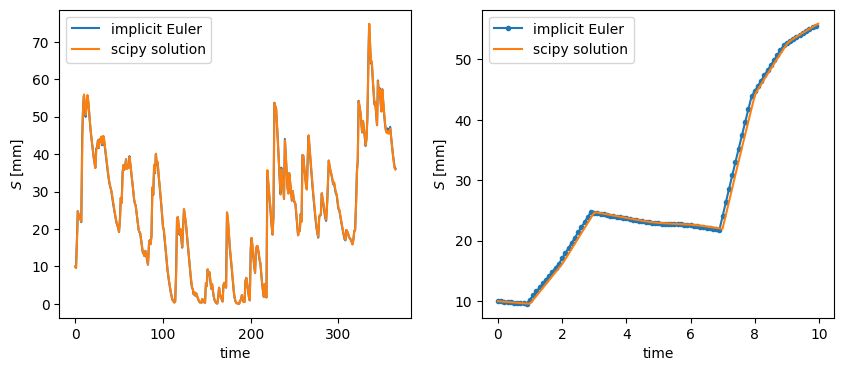

In [11]:
# Plot the implicit Euler solution against a reference solution
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(times, S, label="implicit Euler")
axs[0].plot(sol.t, sol.y[0], label="scipy solution")
axs[0].legend()
axs[0].set_xlabel("time")
axs[0].set_ylabel("$S$ [mm]")

# Zoom in to the first 10 days
mask = times < 10
mask_scipy = sol.t < 10
axs[1].plot(times[mask], S[mask], marker=".", label="implicit Euler")
axs[1].plot(sol.t[mask_scipy], sol.y[0][mask_scipy], label="scipy solution")
axs[1].legend()
axs[1].set_xlabel("time")
axs[1].set_ylabel("$S$ [mm]")


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 3.2:}$
    
Vary the time step, trying values of 0.1, 1 and 10 days.

How does that affect the accuracy of the numerical solution?
    
</p>
</div>


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 3.3:}$
    
Vary the tolerance of the Newton Raphson iterations (keeping a fixed time step of 0.1 days), trying values of $10^{-2}$, $10^{-6}$ and $10^{-10}$.

How does that affect the number of Newton iterations needed on average?
    
</p>
</div>

In a lumped hydrological model like the one we are using, the storage term $S$ cannot be related to any measurable quantity. However, we can compute the discharge from $S$ and compare it to measurements from the station at Meersen.

Remember that the discharge depends on $S$ as follows:

$$Q = k S^\alpha$$

The output will be a discharge that is normalized to the catchment area, in units of mm/day. To compare it to the measurements, we need to multiply it with the catchment area and convert the units to m³/s.


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 3.4:}$
    
Compute the discharge based on the model equation in m³/s and plot it against the measured discharge.
    
</p>
</div>

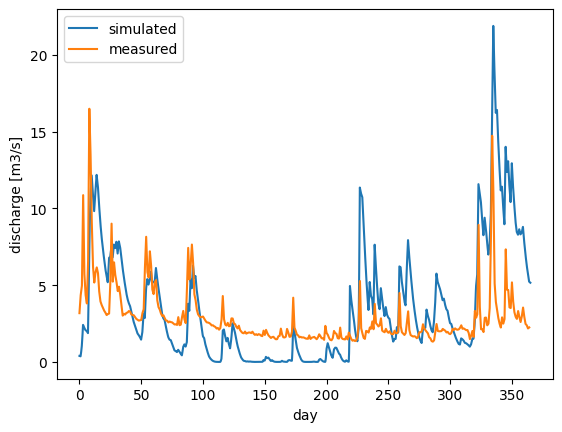

In [12]:
# Compute the discharge from the model output
area = 340e6  # catchment area in m²
Q_mm_per_day = k * S**alpha
Q = Q_mm_per_day * area / 1000 / 86400  # in m³/s

# Plot the simulated and measured discharge
plt.plot(times, Q, label="simulated")
plt.plot(df["days"] / 86400 / 1e9, df["discharge [m3/s]"], label="measured")
plt.xlabel("day")
plt.ylabel("discharge [m3/s]")
plt.legend()


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

$\text{Task 3.5:}$
    
Compare the simulated and the observed discharge: How well does the model match the observations?
Consider that we used a very simplistic model and we cannot realistically expect the simulations to give good predictions.

What features of the discharge timeseries can the model fit well and which ones not? Are there periods when the fit is better than in others?
    
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 90%">
<p>

- The model shows some patterns that can also be observed in the data:
  - precipitation events cause peaks in the discharge that last several days,
  - peaks in summer are lower than peaks in winter.
- However, the overall model fit is poor. Some of the main shortcomings of the model are:
  - In summer, the discharge is generally too low, and sometimes almost drops to zero, whereas the observations show a baseflow in between peaks in summer.
  - The model overpredicts the discharge in the fall and early winter.

This pattern could indicate that the model is lacking a long-term storage term that takes up excess precipitation in the winter, stores it and discharges it as baseflow in the summer.

</p>
</div>

> By Anna Störiko, Ronald Brinkgreve, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html).